In [1]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib import colors
from matplotlib.colors import LogNorm
import matplotlib as mpl 
mpl.rcParams["image.origin"] = 'lower'
# mpl.rcParams["image.dpi"] = 200
import os
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import mplhep as hep
plt.style.use(hep.style.CMS)
#from plotting_utils import *
import uproot
import awkward as ak
import dask.dataframe as dd
from dask.distributed import Client

client = Client(dashboard=True)

/cvmfs/sft.cern.ch/lcg/views/LCG_105a_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/distributed/deploy/local.py:161: UserWarning: Setting `dashboard` is discouraged. Please set `dashboard_address` to affect the scheduler (more common) and `worker_dashboard_address` for the worker (less common).
  warnings.warn(


In [7]:
input_folder = "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/reco_comparison/overlapping_objects_studies/electrons_genmatching"

output_folder = "plots/electrons_gen_matching_v2"
os.makedirs(output_folder, exist_ok=True)
df = pd.HDFStore(f"{input_folder}/Mustache_126X_mcRun3_2023_v1.hdf5", "r")["df"]
df.rename(columns={"output_object.csv":"genpart_index"}, inplace=True)
df = df.iloc[:-1]

#df = dd.from_pandas(df, npartitions=4)

In [4]:
list(df.columns)

['genpart_index',
 'elematched',
 'phomatched',
 'ele_index',
 'pho_index',
 'deltaR_genPart_ele',
 'deltaR_genPart_pho',
 'calomatched',
 'caloindex',
 'sc_matched',
 'sc_index',
 'seed_index',
 'en_seed',
 'et_seed',
 'en_seed_calib',
 'et_seed_calib',
 'seed_eta',
 'seed_phi',
 'seed_iz',
 'sc_eta',
 'sc_phi',
 'sc_swissCross',
 'sc_r9',
 'sc_sigmaIetaIeta',
 'sc_sigmaIetaIphi',
 'sc_sigmaIphiIphi',
 'sc_e5x5',
 'sc_swissCross_f5x5',
 'sc_r9_f5x5',
 'sc_sigmaIetaIeta_f5x5',
 'sc_sigmaIetaIphi_f5x5',
 'sc_sigmaIphiIphi_f5x5',
 'sc_e5x5_f5x5',
 'ele_eta',
 'ele_phi',
 'ele_energy',
 'ele_et',
 'ele_ecalEnergy',
 'ele_ecalSCEnergy',
 'ele_scRawEnergy',
 'ele_scRawESEnergy',
 'ele_SCfbrem',
 'ele_tracfbrem',
 'ele_e5x5',
 'ele_e3x3',
 'ele_sigmaIEtaIEta',
 'ele_sigmaIEtaIPhi',
 'ele_sigmaIPhiIPhi',
 'ele_ecalIso03',
 'ele_trkIso03',
 'ele_hcalIso03',
 'ele_pfChargedHadronIso',
 'ele_pfNeutralHadronIso',
 'ele_pfPhotonIso',
 'ele_HoE',
 'ele_deltaEtaSeedClusterAtCalo',
 'ele_deltaPhiSeed

In [3]:
def calculate_mean_std(column):
    mean = column.mean()
    std = column.std()
    return pd.Series({'mean': mean, 'std': std})
grouped_stats = df.groupby(['runId', 'eventId'])['genpart_et'].apply(calculate_mean_std)
print(grouped_stats)

runId    eventId      
1.0      1.0      mean    268.451014
                  std     135.683647
         2.0      mean    312.736193
                  std     116.624841
         3.0      mean    116.826430
                             ...    
10000.0  48.0     std     139.090889
         49.0     mean    287.384393
                  std     162.700055
         50.0     mean    179.264867
                  std     133.208210
Name: genpart_et, Length: 1000000, dtype: float64


In [8]:
def calculate_deltaR(group):
    # Extract relevant columns
    eta = group['calo_geneta'].values
    phi = group['calo_genphi'].values
    calo_et_gen = group['calo_et_gen'].values
    ele_et=group['ele_et'].values
    ele_index = group['ele_index'].values
    elematched = group['elematched'].values
    
    # Calculate differences and means
    eta_diff = eta[::2] - eta[1::2]
    dphi = (phi[::2] - phi[1::2])
    dphi[dphi > np.pi] -= 2 * np.pi
    dphi[dphi < -np.pi] += 2 * np.pi
    dr_diff = np.sqrt(eta_diff**2 + dphi**2)
    eta_mean = (eta[::2] + eta[1::2]) / 2
    phi_mean = (phi[::2] + phi[1::2]) / 2
    
    data = {
        'deltaR': dr_diff,
        'eta_mean': eta_mean,
        'phi_mean': phi_mean,
        "calo_energy1": calo_et_gen[::2],
        'calo_energy2': calo_et_gen[1::2],
        'ele_et1':ele_et[::2],
        'ele_et2':ele_et[1::2],
        'ele_index1': ele_index[::2],
        'ele_index2': ele_index[1::2],
        'ele_matched1': elematched[::2],
        'ele_matched2': elematched[1::2],
    }
    
    return pd.DataFrame(data)

grouped_deltas = df.groupby(['runId', 'eventId']).apply(calculate_deltaR)
grouped_deltas.to_csv('grouped_deltas.csv', index=False)  # Specify index=False to exclude the index from the CSV file

print(grouped_deltas)


                     deltaR  eta_mean  phi_mean  calo_energy1  calo_energy2  \
runId   eventId                                                               
1.0     1.0     0  0.556688 -1.996164 -0.380098    154.856923    306.222130   
                1  0.320304 -0.050764  1.119241    224.221211    402.985241   
                2  0.375094  0.295347 -2.013023      5.700451    299.433254   
                3  0.335604  2.580305 -2.770359    398.068529    356.120304   
        2.0     0  0.119264 -1.800459  1.549486    435.421870    165.661081   
...                     ...       ...       ...           ...           ...   
10000.0 49.0    3  0.089079  2.324892  0.948665    233.337585    232.570326   
        50.0    0  0.653780 -2.461027  1.025318    202.269233    246.267392   
                1  0.166304 -1.330883 -2.856730    104.928943    119.131560   
                2  0.440140  0.856887 -0.171696     23.532720    134.001787   
                3  0.571429  2.118894  2.018532    1

In [10]:
valid_energy_mask = (grouped_deltas['calo_energy1'] != -999.0) | (grouped_deltas['calo_energy2'] != -999)
grouped_deltas = grouped_deltas[valid_energy_mask]

# Event same ele_index

In [2]:
grouped_deltas = pd.read_csv('grouped_deltas.csv')
valid_energy_mask = (grouped_deltas['energy1'] != -999.0) & (grouped_deltas['energy2'] != -999)
grouped_deltas = grouped_deltas[valid_energy_mask]

In [11]:
same_ele_index_mask = grouped_deltas['ele_index1'] == grouped_deltas['ele_index2']
same_ele_events = grouped_deltas[same_ele_index_mask]
print(same_ele_events)

                     deltaR  eta_mean  phi_mean  calo_energy1  calo_energy2  \
runId   eventId                                                               
1.0     3.0     0  0.396164 -2.731669  1.005955     74.392717     75.991463   
                3  0.000000  2.361738 -2.881292    167.584058    167.584058   
        4.0     2  0.408611  1.463442  0.081365    381.190756    447.693415   
                3  0.664554  2.216470 -0.587010    268.397434    159.325919   
        6.0     0  0.057895 -1.866780 -0.287161    488.966574    164.659487   
...                     ...       ...       ...           ...           ...   
10000.0 46.0    2  1.308405 -0.542383 -0.532488     -1.000000     58.471184   
        47.0    1  0.259072 -0.342276 -1.717838     50.851507     67.029474   
                3  0.000000 -1.000000 -1.000000     -1.000000     -1.000000   
        48.0    0  0.535124 -2.783971  1.412874    326.650902     42.936397   
        49.0    0  0.258128 -2.157016  2.394996    4

In [13]:
max_energy1 = (same_ele_events['calo_energy1']/same_ele_events['calo_energy2']).max()
min_energy1 = same_ele_events['calo_energy1'].min()

# Print the maximum and minimum values
print("Maximum energy1:", max_energy1)
print("Minimum energy1:", min_energy1)

Maximum energy1: 353.68054148157364
Minimum energy1: -1.0


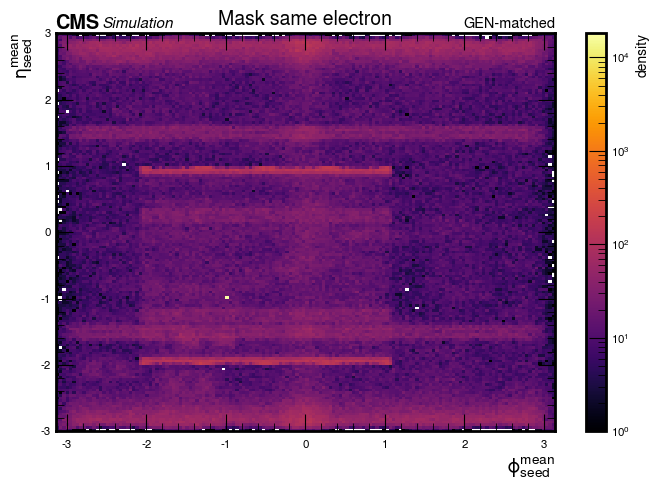

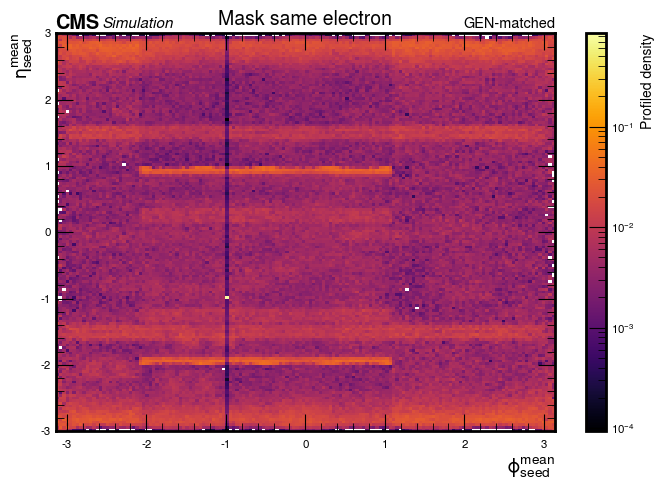

In [14]:
fig, ax = plt.subplots(1,1,dpi=100, figsize=(7, 5))

A,xedges,yedges  = np.histogram2d(same_ele_events.phi_mean ,same_ele_events.eta_mean,bins=(150, 150), range=((-np.pi,np.pi),(-3,3)))

s = 1#np.expand_dims(np.sum(A, axis=-1), axis=1)
a = A/s
X, Y = np.meshgrid(xedges, yedges)
I = ax.pcolormesh(X, Y, a.T, norm=LogNorm(), cmap="inferno")

fig.colorbar(I, ax=ax, label="density")
ax.set_ylabel("$\eta^{mean}_{seed}$", fontsize=14)
ax.set_xlabel("$\phi^{mean}_{seed}$", fontsize=14)
plt.title('Mask same electron',fontsize=14)
hep.cms.label(llabel="Simulation", rlabel="GEN-matched", loc=0, ax=ax,fontsize=11)
plt.tight_layout()
plt.savefig('plots/eta_phi.png')
plt.show()
fig, ax = plt.subplots(1,1,dpi=100, figsize=(7, 5))

A,xedges,yedges  = np.histogram2d(same_ele_events.phi_mean ,same_ele_events.eta_mean,bins=(150, 150), range=((-np.pi,np.pi),(-3,3)))

s = np.expand_dims(np.sum(A, axis=-1), axis=1)
a = A/s
X, Y = np.meshgrid(xedges, yedges)
I = ax.pcolormesh(X, Y, a.T, norm=LogNorm(), cmap="inferno")

fig.colorbar(I, ax=ax, label="Profiled density")
ax.set_ylabel("$\eta^{mean}_{seed}$", fontsize=14)
ax.set_xlabel("$\phi^{mean}_{seed}$", fontsize=14)
plt.title('Mask same electron',fontsize=14)
hep.cms.label(llabel="Simulation", rlabel="GEN-matched", loc=0, ax=ax,fontsize=11)
plt.tight_layout()
plt.savefig('plots/eta_phi_prof.png')


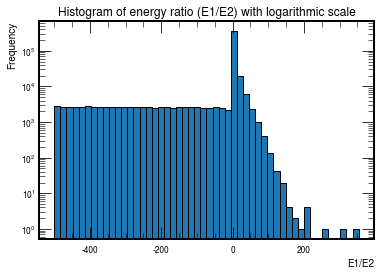

min energyratio:  -499.999859377693


In [16]:

energy_ratio = same_ele_events['calo_energy1'] / same_ele_events['calo_energy2']
energy_ratio[same_ele_events['calo_energy1'] < same_ele_events['calo_energy2']] = same_ele_events['calo_energy2'] / same_ele_events['calo_energy1']

plt.hist(energy_ratio, bins=50, edgecolor='black', log=True)  # Set log=True
plt.xlabel('E1/E2')
plt.ylabel('Frequency')
plt.title('Histogram of energy ratio (E1/E2) with logarithmic scale')
plt.savefig('plots/hist_e1-e2.png')
plt.show()
print('min energyratio: ', energy_ratio.min())

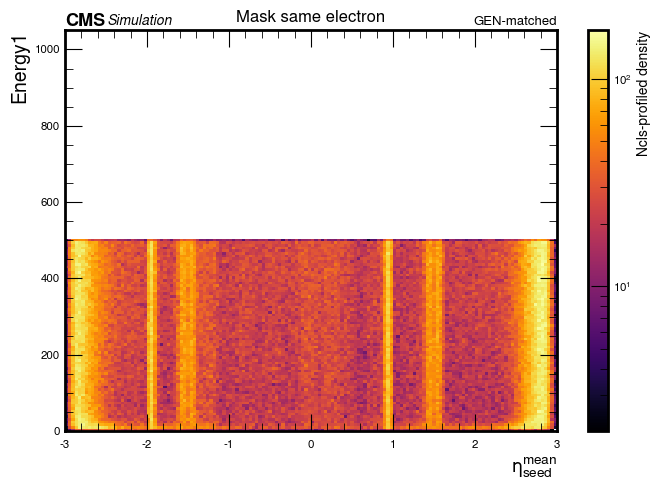

In [17]:
fig, ax = plt.subplots(1,1,dpi=100, figsize=(7, 5))

A,xedges,yedges  = np.histogram2d(same_ele_events.eta_mean ,same_ele_events.calo_energy1,bins=(150, 150), range=((-3,3),(0,1050)))

s = 1#np.expand_dims(np.sum(A, axis=-1), axis=1)
a = A/s
X, Y = np.meshgrid(xedges, yedges)
I = ax.pcolormesh(X, Y, a.T, norm=LogNorm(), cmap="inferno")

fig.colorbar(I, ax=ax, label="Ncls-profiled density")
ax.set_xlabel("$\eta^{mean}_{seed}$", fontsize=14)
ax.set_ylabel("Energy1", fontsize=14)
plt.title('Mask same electron')
hep.cms.label(llabel="Simulation", rlabel="GEN-matched", loc=0, ax=ax)
plt.tight_layout()
plt.savefig('plots/e1_eta.png')

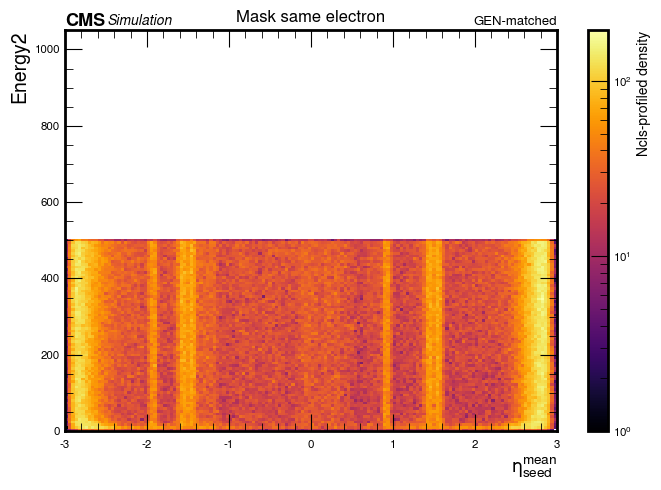

In [18]:
fig, ax = plt.subplots(1,1,dpi=100, figsize=(7, 5))

A,xedges,yedges  = np.histogram2d(same_ele_events.eta_mean ,same_ele_events.calo_energy2,bins=(150, 150), range=((-3,3),(0,1050)))

s = 1#np.expand_dims(np.sum(A, axis=-1), axis=1)
a = A/s
X, Y = np.meshgrid(xedges, yedges)
I = ax.pcolormesh(X, Y, a.T, norm=LogNorm(), cmap="inferno")

fig.colorbar(I, ax=ax, label="Ncls-profiled density")
ax.set_xlabel("$\eta^{mean}_{seed}$", fontsize=14)
ax.set_ylabel("Energy2", fontsize=14)
plt.title('Mask same electron')
hep.cms.label(llabel="Simulation", rlabel="GEN-matched", loc=0, ax=ax)
plt.tight_layout()
plt.savefig('plots/e2_eta.png')

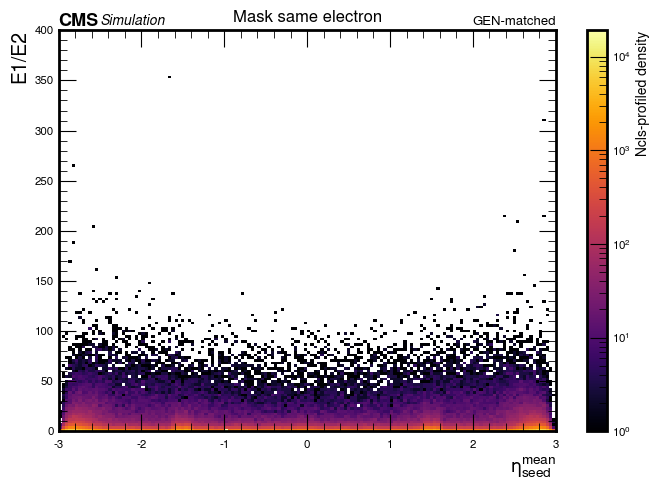

In [19]:
fig, ax = plt.subplots(1,1,dpi=100, figsize=(7, 5))

A,xedges,yedges  = np.histogram2d(same_ele_events.eta_mean ,energy_ratio,bins=(150, 150), range=((-3,3),(0,400)))

s = 1#np.expand_dims(np.sum(A, axis=-1), axis=1)
a = A/s
X, Y = np.meshgrid(xedges, yedges)
I = ax.pcolormesh(X, Y, a.T, norm=LogNorm(), cmap="inferno")

fig.colorbar(I, ax=ax, label="Ncls-profiled density")
ax.set_xlabel("$\eta^{mean}_{seed}$", fontsize=14)
ax.set_ylabel("E1/E2", fontsize=14)
plt.title('Mask same electron')
hep.cms.label(llabel="Simulation", rlabel="GEN-matched", loc=0, ax=ax)
plt.tight_layout()
plt.savefig('plots/e1-e2_eta.png')

In [20]:
total_events = len(grouped_deltas)

same_ele_index_events = grouped_deltas[grouped_deltas['ele_index1'] == grouped_deltas['ele_index2']]
same_ele_index_count = len(same_ele_index_events)
percentage_same_ele_index = (same_ele_index_count / total_events) * 100

print(f"Percentage of events with the same ele_index: {percentage_same_ele_index:.2f}%")

Percentage of events with the same ele_index: 23.00%


In [21]:
eta_mean_range = (1.4, 1.6)

filtered_events = grouped_deltas[(grouped_deltas['eta_mean'] >= eta_mean_range[0]) & 
                                 (grouped_deltas['eta_mean'] <= eta_mean_range[1]) &
                                 (grouped_deltas['ele_index1'] == grouped_deltas['ele_index2'])]

total_events_eta_range = len(grouped_deltas[(grouped_deltas['eta_mean'] >= eta_mean_range[0]) & 
                                             (grouped_deltas['eta_mean'] <= eta_mean_range[1])])

same_ele_eta_range_count = len(filtered_events)
percentage_same_ele_index_eta_range = (same_ele_eta_range_count / total_events_eta_range) * 100
print(f"Percentage of events with the same ele_index in the range eta {eta_mean_range}: {percentage_same_ele_index_eta_range:.2f}%"

SyntaxError: unexpected EOF while parsing (983013716.py, line 12)

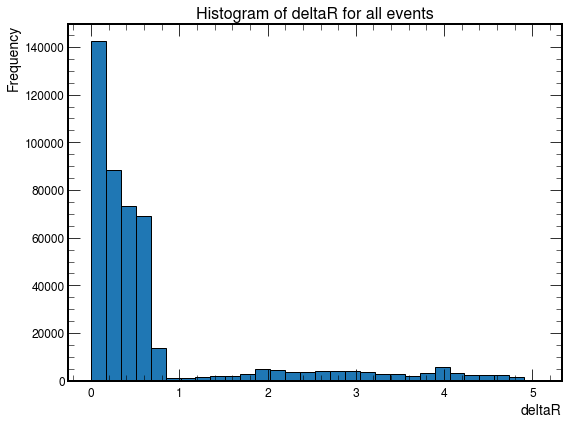

In [22]:
plt.figure(figsize=(8, 6))  
plt.hist(same_ele_events['deltaR'], bins=30, edgecolor='black')
plt.xlabel('deltaR', fontsize=14)  
plt.ylabel('Frequency', fontsize=14)  
plt.title('Histogram of deltaR for all events', fontsize=16)  
plt.xticks(fontsize=12) 
plt.yticks(fontsize=12) 
plt.tight_layout() 
plt.savefig('plots/deltaR_histogram.png')
plt.show()

In [23]:
print('delta r max: ',same_ele_events['deltaR'].max())

delta r max:  5.075952505948273


interval=[ 0.0 1.0151905011896545 ]
n1:  289085
ntot:  1808753
interval=[ 1.0151905011896545 2.030381002379309 ]
n1:  14645
ntot:  17694
interval=[ 2.030381002379309 3.0455715035689632 ]
n1:  24380
ntot:  29358
interval=[ 3.0455715035689632 4.060762004758618 ]
n1:  20838
ntot:  23828
interval=[ 4.060762004758618 5.075952505948273 ]
n1:  12630
ntot:  14041


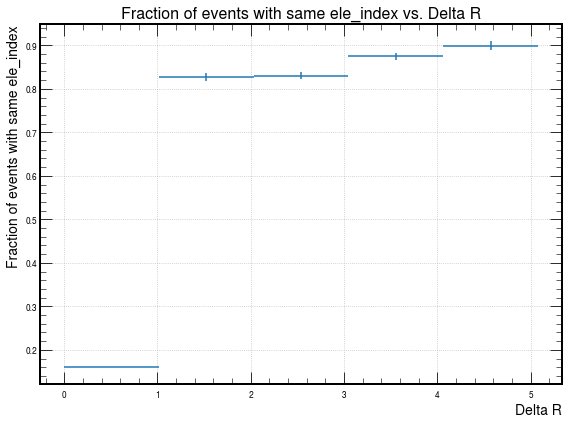

In [24]:
def fraction_same_ele_index_vs_deltaR(num_intervals):
    deltaR_max = same_ele_events['deltaR'].max()
    deltaR_values, y = np.linspace(0, deltaR_max, num_intervals + 1, retstep=True)

    fraction_list = []
    yer = []

    for i in range(len(deltaR_values) - 1):
        lower_bound = deltaR_values[i]
        upper_bound = deltaR_values[i + 1]
        print('interval=[',lower_bound,upper_bound,']')
        mask = (same_ele_events['deltaR'] > lower_bound) & (same_ele_events['deltaR'] <= upper_bound)
        mask2 = (grouped_deltas['deltaR'] > lower_bound) & (grouped_deltas['deltaR'] <= upper_bound)

        n1 = len(same_ele_events[mask])
        print('n1: ',n1)
        ntot = len(grouped_deltas[mask2])
        print('ntot: ',ntot)
        if ntot == 0:
            ntot = 1
        fraction = n1 / ntot
        fraction_list.append(fraction)
        yer.append(np.sqrt(n1 + n1**2 / ntot) / ntot)

    plt.figure(figsize=(8,6))  # Larger figsize
    plt.errorbar(deltaR_values[:-1] + y / 2, fraction_list, xerr=np.ones(num_intervals) * y / 2, yerr=yer, fmt='none')
    #plt.scatter(deltaR_values[:-1] + y / 2, fraction_list)
    plt.xlabel('Delta R', fontsize=14)
    plt.ylabel('Fraction of events with same ele_index', fontsize=14) 
    plt.title('Fraction of events with same ele_index vs. Delta R', fontsize=16)  
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('plots/fraction_deltaR.png')
    plt.show()

num_intervals = 5
fraction_same_ele_index_vs_deltaR(num_intervals)
